# Fourier Fields Optimization in Waveguide Bend

Previously, optimization of eigenmode coefficient in a waveguide bend was presented. We set up a similar example but directly optimizing Fourier Fields instead. We point out a few subtle differences.



In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import special, signal

mp.quiet(quietval=True)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

The code for eigenmode coefficient uses Yee grid directly. The implementation of Fourier fields doesn't use Yee_grid directly. We thus increase the resolution from 30 to 40 to achieve the desired level of accuracy.

In [2]:
waveguide_width = 0.5
design_region_width = 2.5
design_region_height = 2.5

waveguide_length = 0.5

pml_size = 1.0

resolution = 40

frequencies = 1 / np.linspace(1.5, 1.6, 3)

In [3]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
print(filter_radius)
design_region_resolution = int(1 * resolution)

0.20124611797498096


In [4]:
Sx = 2 * pml_size + 2 * waveguide_length + design_region_width + 2
Sy = 2 * pml_size + design_region_height + 2
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [-Sx / 2 + pml_size + waveguide_length / 3, 0, 0]
source_size = mp.Vector3(0, Sy, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

In [5]:
Nx = int(design_region_resolution * design_region_width)
Ny = int(design_region_resolution * design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

In [6]:
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width / 2)
top_wg_mask = (Y_g == design_region_width / 2) & (np.abs(X_g) <= waveguide_width / 2)
Si_mask = left_wg_mask | top_wg_mask

border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

In [7]:
def mapping(x, eta, beta):
    x = npa.where(Si_mask.flatten(), 1, npa.where(SiO2_mask.flatten(), 0, x))
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return projected_field.flatten()

When building the geometry, we removed the symmetry requirement to have more flexibility.

In [8]:
geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 0.5, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(y=Sy / 4), material=Si, size=mp.Vector3(0.5, Sy / 2, 0)
    ),  # vertical waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=SiO2,
    resolution=resolution,
)

Defining mpa.FourierFields is similar to define mpa.EigenmodeCoefficient, but we pass a component of interest intead of mode number. We can define several components, and let the objective be a function of them simultaneously.

The first axis of the value returned by Fourier Fields corresponds to the index of frequency; the rest has the dimensions of the monitor. In this case, it is 1D, so we simply provide the index of point at which we would like to optimize the fields.

The objective function can involve several fields component, at several frequencies, and involve several points. Since we specify the points by indices, it is probably more common to have an objective as an average/sum of values at all points, where we don't need specific indices and just use `:` instead.

Also note that the optimization problem includes a wider frequency spectrum, but the particular objective defined below depends on one frequency only. Alternatively, we can define a single frequency from the start.

In [9]:
Ez_top = mpa.FourierFields(
    sim,
    mp.Volume(
        center=mp.Vector3(0, Sy / 2 - pml_size - 0.1, 0),
        size=mp.Vector3(x=waveguide_width),
    ),
    mp.Ez,
)
ob_list = [Ez_top]


def J(top):
    power = npa.abs(top[1, 7]) ** 2
    return power

Just as we increased the resolution, we decreased the decay_by to $10^{-6}$ to increase the accuracy of the adjoint gradient. We also increase the number of iterations for each `beta`.

In [10]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-6,
    decay_fields=[mp.Ez],
)

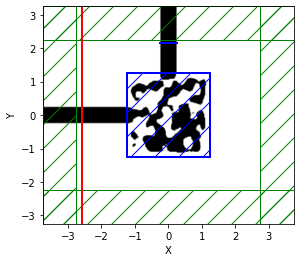

In [11]:
rho_vector = np.random.rand(Nx * Ny)
opt.update_design([mapping(rho_vector, eta_i, 1e3)])
opt.plot2D(True)
plt.show()

In [12]:
evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    # plt.savefig('media/bend_{:03d}.png'.format(cur_iter[0]),dpi=300)
    plt.show()

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

Current iteration: 1
Starting forward run...
Starting adjoint run...


/usr/local/lib/python3.8/site-packages/meep/adjoint/filter_source.py:91: RuntimeWarning: invalid value encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat.T)**2/np.abs(H)**2)
/usr/local/lib/python3.8/site-packages/meep/adjoint/filter_source.py:91: RuntimeWarning: divide by zero encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat.T)**2/np.abs(H)**2)


Calculating gradient...


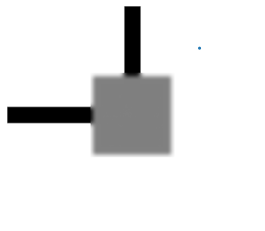

Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...


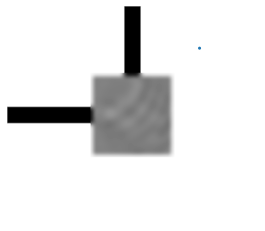

Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...


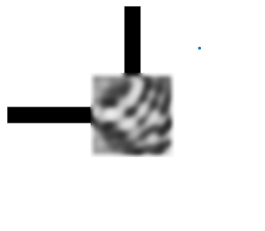

Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


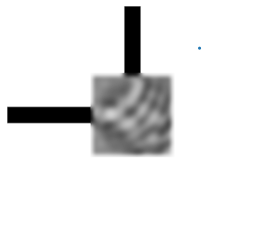

Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...


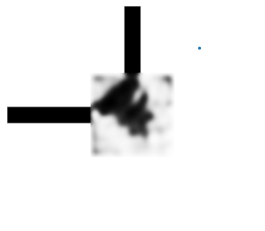

Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...


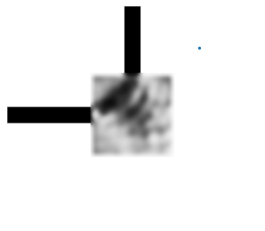

Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...


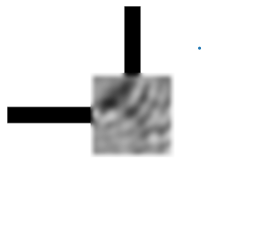

Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


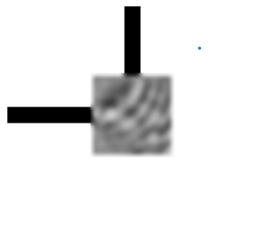

Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...


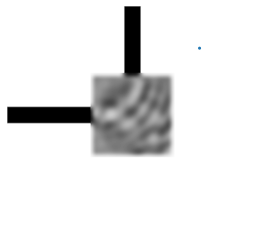

Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...


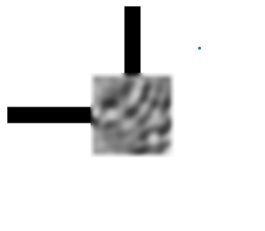

Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...


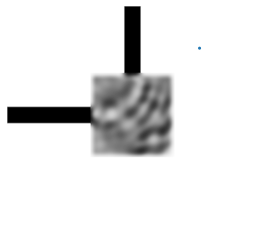

Current iteration: 12
Starting forward run...
Starting adjoint run...
Calculating gradient...


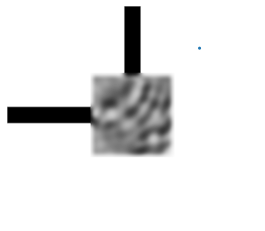

Current iteration: 13
Starting forward run...
Starting adjoint run...
Calculating gradient...


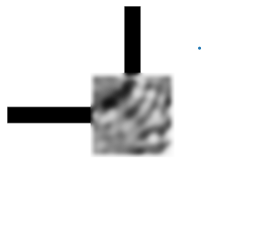

Current iteration: 14
Starting forward run...
Starting adjoint run...
Calculating gradient...


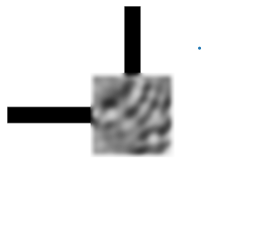

Current iteration: 15
Starting forward run...
Starting adjoint run...
Calculating gradient...


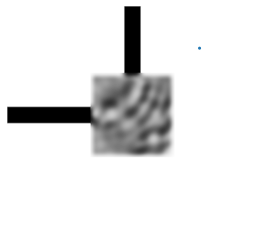

Current iteration: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


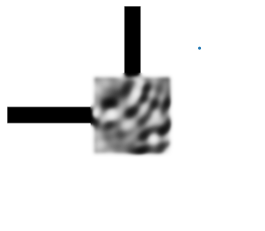

Current iteration: 17
Starting forward run...
Starting adjoint run...
Calculating gradient...


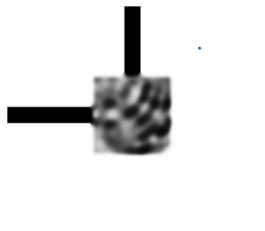

Current iteration: 18
Starting forward run...
Starting adjoint run...
Calculating gradient...


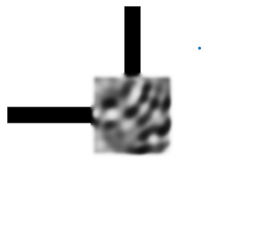

Current iteration: 19
Starting forward run...
Starting adjoint run...
Calculating gradient...


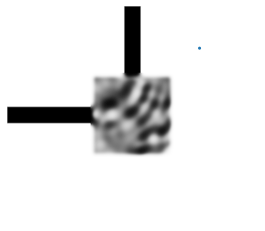

Current iteration: 20
Starting forward run...
Starting adjoint run...
Calculating gradient...


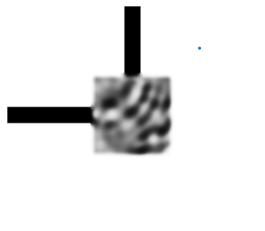

Current iteration: 21
Starting forward run...
Starting adjoint run...
Calculating gradient...


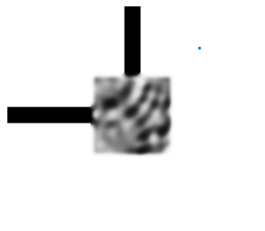

Current iteration: 22
Starting forward run...
Starting adjoint run...
Calculating gradient...


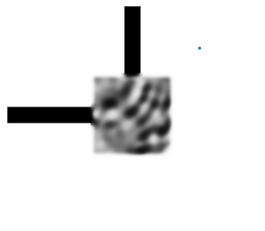

Current iteration: 23
Starting forward run...
Starting adjoint run...
Calculating gradient...


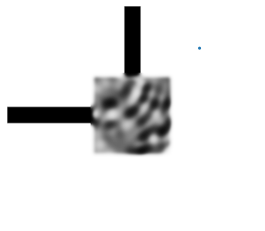

Current iteration: 24
Starting forward run...
Starting adjoint run...
Calculating gradient...


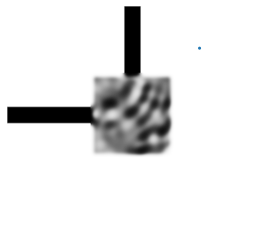

Current iteration: 25
Starting forward run...
Starting adjoint run...
Calculating gradient...


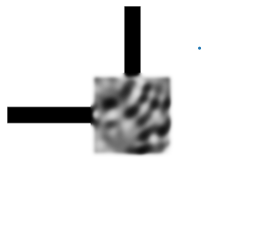

Current iteration: 26
Starting forward run...
Starting adjoint run...
Calculating gradient...


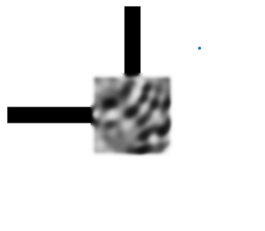

Current iteration: 27
Starting forward run...
Starting adjoint run...
Calculating gradient...


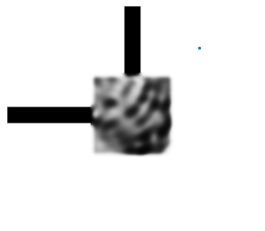

Current iteration: 28
Starting forward run...
Starting adjoint run...
Calculating gradient...


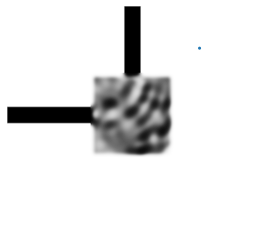

Current iteration: 29
Starting forward run...
Starting adjoint run...
Calculating gradient...


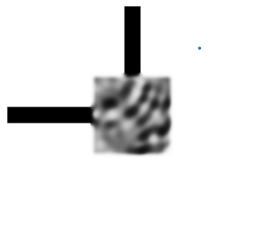

Current iteration: 30
Starting forward run...
Starting adjoint run...
Calculating gradient...


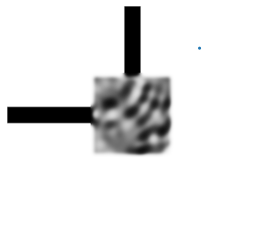

Current iteration: 31
Starting forward run...
Starting adjoint run...
Calculating gradient...


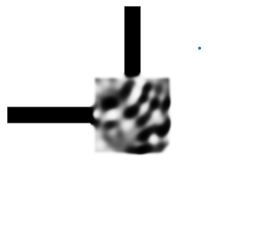

Current iteration: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


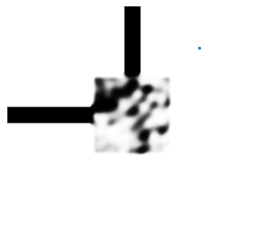

Current iteration: 33
Starting forward run...
Starting adjoint run...
Calculating gradient...


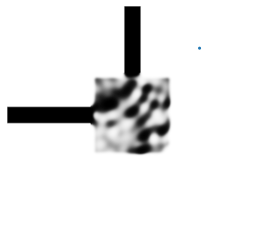

Current iteration: 34
Starting forward run...
Starting adjoint run...
Calculating gradient...


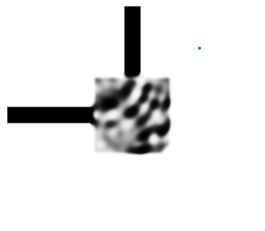

Current iteration: 35
Starting forward run...
Starting adjoint run...
Calculating gradient...


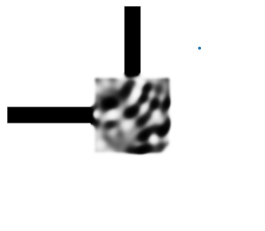

Current iteration: 36
Starting forward run...
Starting adjoint run...
Calculating gradient...


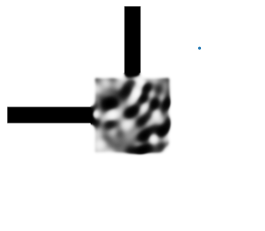

Current iteration: 37
Starting forward run...
Starting adjoint run...
Calculating gradient...


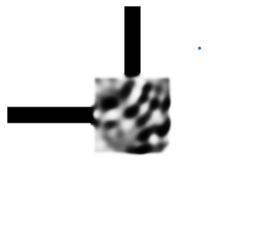

Current iteration: 38
Starting forward run...
Starting adjoint run...
Calculating gradient...


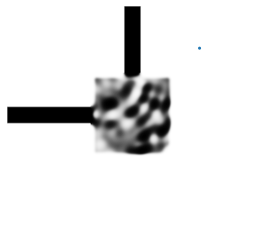

Current iteration: 39
Starting forward run...
Starting adjoint run...
Calculating gradient...


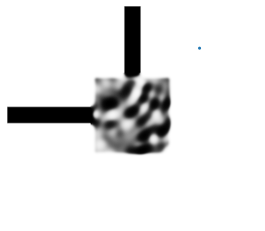

Current iteration: 40
Starting forward run...
Starting adjoint run...
Calculating gradient...


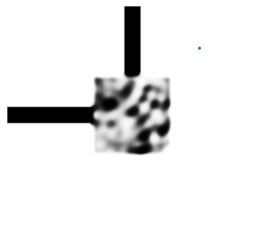

Current iteration: 41
Starting forward run...
Starting adjoint run...
Calculating gradient...


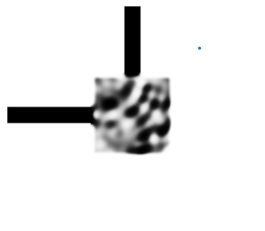

Current iteration: 42
Starting forward run...
Starting adjoint run...
Calculating gradient...


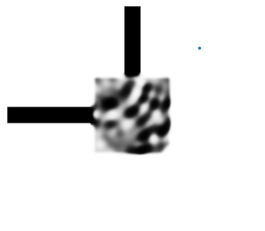

Current iteration: 43
Starting forward run...
Starting adjoint run...
Calculating gradient...


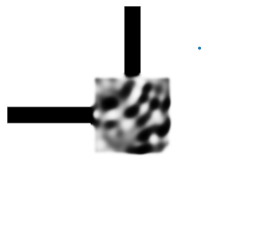

Current iteration: 44
Starting forward run...
Starting adjoint run...
Calculating gradient...


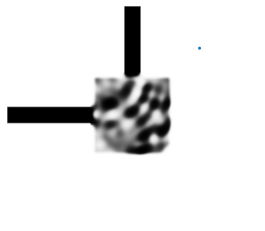

Current iteration: 45
Starting forward run...
Starting adjoint run...
Calculating gradient...


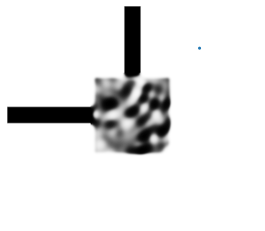

Current iteration: 46
Starting forward run...
Starting adjoint run...
Calculating gradient...


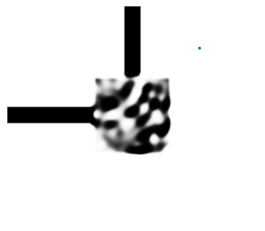

Current iteration: 47
Starting forward run...
Starting adjoint run...
Calculating gradient...


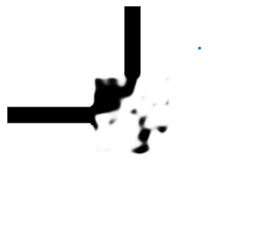

Current iteration: 48
Starting forward run...
Starting adjoint run...
Calculating gradient...


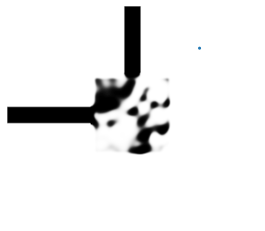

Current iteration: 49
Starting forward run...
Starting adjoint run...
Calculating gradient...


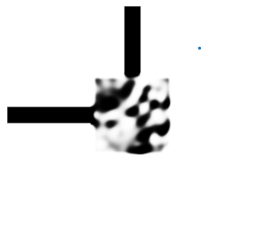

Current iteration: 50
Starting forward run...
Starting adjoint run...
Calculating gradient...


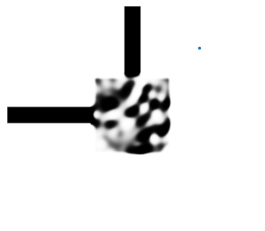

Current iteration: 51
Starting forward run...
Starting adjoint run...
Calculating gradient...


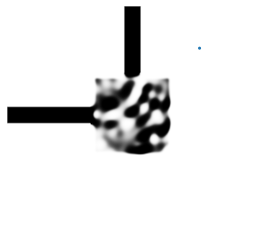

Current iteration: 52
Starting forward run...
Starting adjoint run...
Calculating gradient...


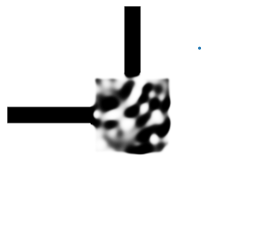

Current iteration: 53
Starting forward run...
Starting adjoint run...
Calculating gradient...


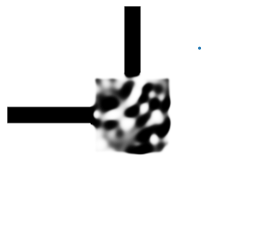

Current iteration: 54
Starting forward run...
Starting adjoint run...
Calculating gradient...


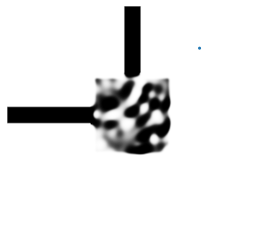

Current iteration: 55
Starting forward run...
Starting adjoint run...
Calculating gradient...


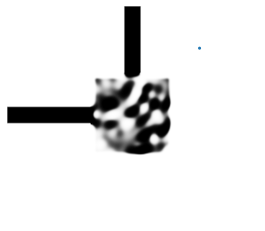

Current iteration: 56
Starting forward run...
Starting adjoint run...
Calculating gradient...


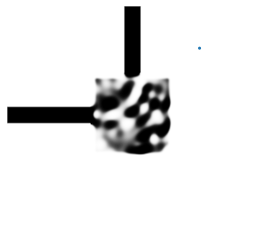

Current iteration: 57
Starting forward run...
Starting adjoint run...
Calculating gradient...


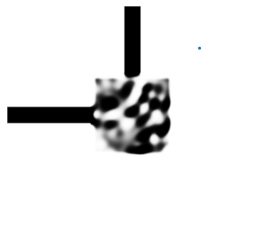

Current iteration: 58
Starting forward run...
Starting adjoint run...
Calculating gradient...


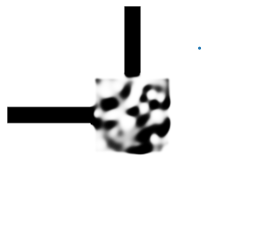

Current iteration: 59
Starting forward run...
Starting adjoint run...
Calculating gradient...


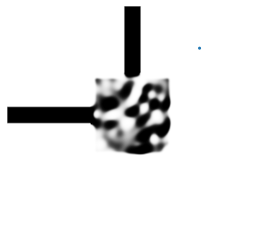

Current iteration: 60
Starting forward run...
Starting adjoint run...
Calculating gradient...


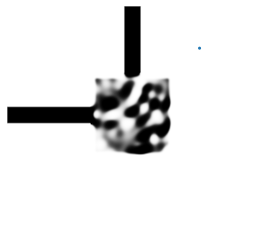

Current iteration: 61
Starting forward run...
Starting adjoint run...
Calculating gradient...


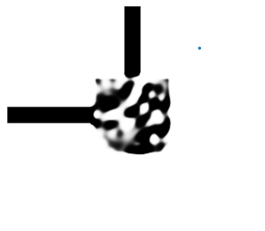

Current iteration: 62
Starting forward run...
Starting adjoint run...
Calculating gradient...


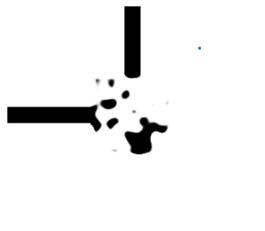

Current iteration: 63
Starting forward run...
Starting adjoint run...
Calculating gradient...


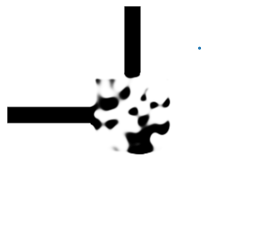

Current iteration: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


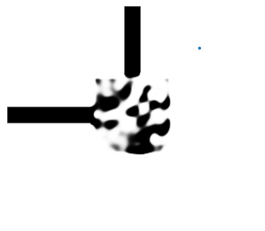

Current iteration: 65
Starting forward run...
Starting adjoint run...
Calculating gradient...


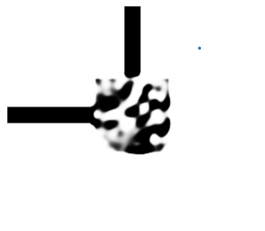

Current iteration: 66
Starting forward run...
Starting adjoint run...
Calculating gradient...


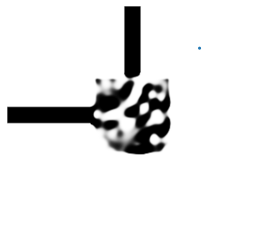

Current iteration: 67
Starting forward run...
Starting adjoint run...
Calculating gradient...


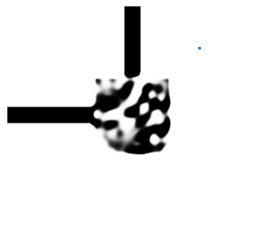

Current iteration: 68
Starting forward run...
Starting adjoint run...
Calculating gradient...


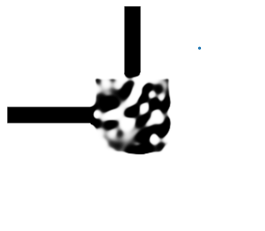

Current iteration: 69
Starting forward run...
Starting adjoint run...
Calculating gradient...


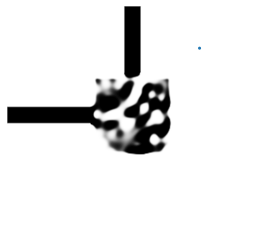

Current iteration: 70
Starting forward run...
Starting adjoint run...
Calculating gradient...


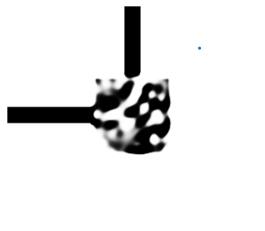

Current iteration: 71
Starting forward run...
Starting adjoint run...
Calculating gradient...


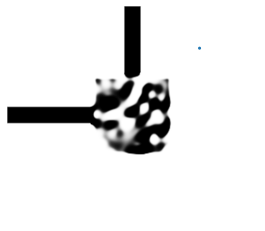

Current iteration: 72
Starting forward run...
Starting adjoint run...
Calculating gradient...


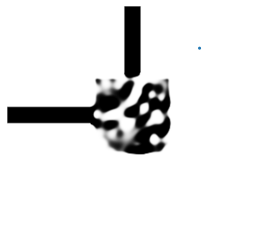

Current iteration: 73
Starting forward run...
Starting adjoint run...
Calculating gradient...


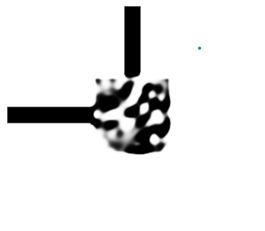

Current iteration: 74
Starting forward run...
Starting adjoint run...
Calculating gradient...


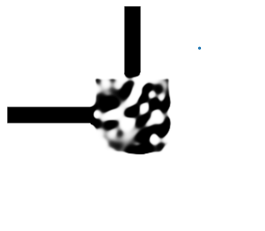

Current iteration: 75
Starting forward run...
Starting adjoint run...
Calculating gradient...


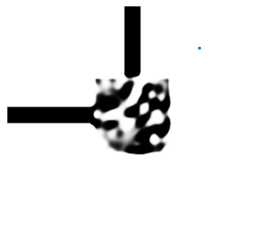

Current iteration: 76
Starting forward run...
Starting adjoint run...
Calculating gradient...


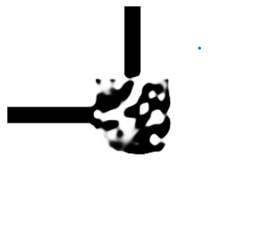

Current iteration: 77
Starting forward run...
Starting adjoint run...
Calculating gradient...


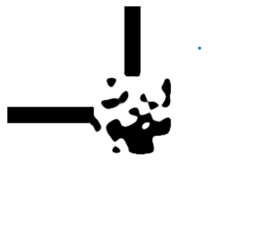

Current iteration: 78
Starting forward run...
Starting adjoint run...
Calculating gradient...


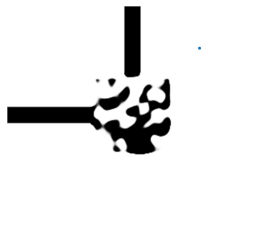

Current iteration: 79
Starting forward run...
Starting adjoint run...
Calculating gradient...


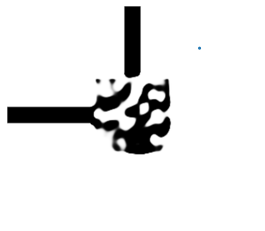

Current iteration: 80
Starting forward run...
Starting adjoint run...
Calculating gradient...


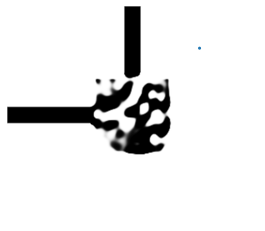

Current iteration: 81
Starting forward run...
Starting adjoint run...
Calculating gradient...


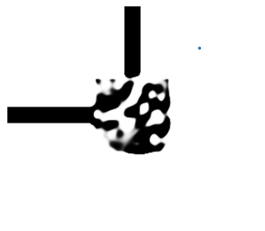

Current iteration: 82
Starting forward run...
Starting adjoint run...
Calculating gradient...


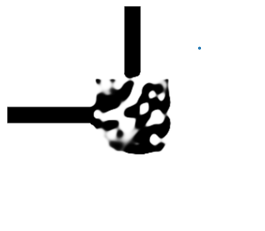

Current iteration: 83
Starting forward run...
Starting adjoint run...
Calculating gradient...


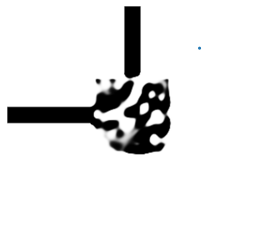

Current iteration: 84
Starting forward run...
Starting adjoint run...
Calculating gradient...


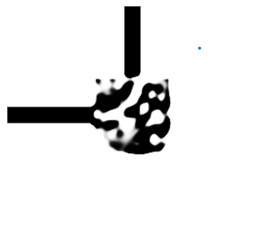

Current iteration: 85
Starting forward run...
Starting adjoint run...
Calculating gradient...


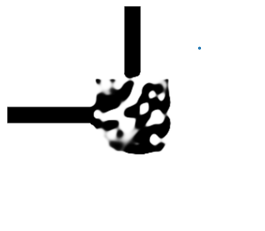

Current iteration: 86
Starting forward run...
Starting adjoint run...
Calculating gradient...


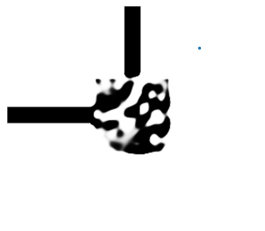

Current iteration: 87
Starting forward run...
Starting adjoint run...
Calculating gradient...


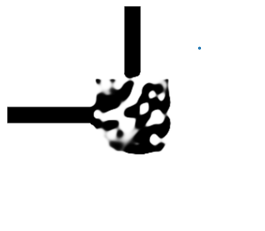

Current iteration: 88
Starting forward run...
Starting adjoint run...
Calculating gradient...


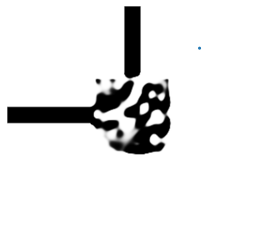

Current iteration: 89
Starting forward run...
Starting adjoint run...
Calculating gradient...


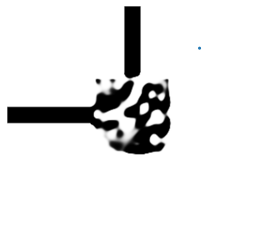

Current iteration: 90
Starting forward run...
Starting adjoint run...
Calculating gradient...


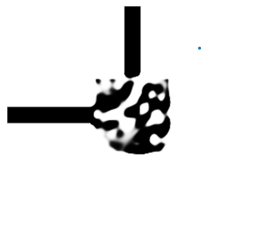

In [13]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1  # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0  # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx * Ny,))
ub[SiO2_mask.flatten()] = 0

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 15
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_xtol_rel(1e-4)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

We'll wait for a few minutes (or longer) and visualize the results. We see that every time `beta` increases it either drives the cost function out of a local minimum or into a poorer spot. It gets harder to converge as `beta` increases. This is expected as the gradient starts to swing wildy at these thresholded transition regions. Regardless, we are still able to generate a somewhat smoothed structure after just 72 iterations.

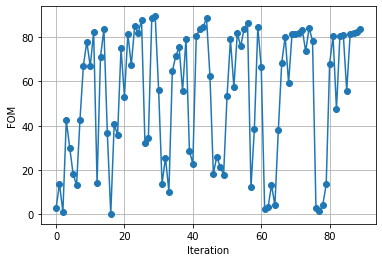

In [14]:
plt.figure()
plt.plot((evaluation_history), "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

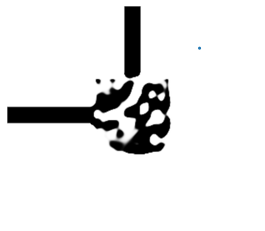

In [15]:
opt.update_design([mapping(x, eta_i, cur_beta)])
plt.figure()
ax = plt.gca()
opt.plot2D(
    False,
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

We can plot the fields of the monitor at different for the frequency of interest. We can see that indeed the point with index 7 has the largest value, as expected.

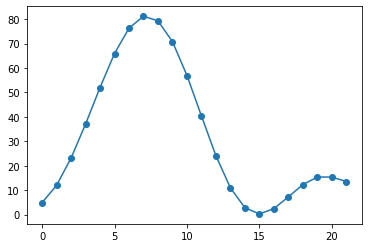

In [16]:
f0, dJ_du = opt([mapping(x, eta_i, cur_beta)], need_gradient=False)
Ez_coef = opt.get_objective_arguments()[0]
plt.figure()
plt.plot(np.abs(Ez_coef[1, :]) ** 2, "-o")
plt.show()

<AxesSubplot:xlabel='X', ylabel='Y'>

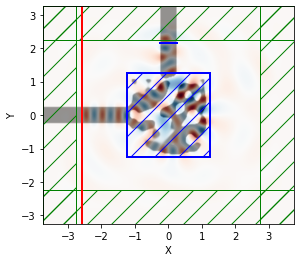

In [17]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]
opt.sim.change_sources(source)
opt.sim.run(until=500)
opt.sim.plot2D(fields=mp.Ez)